### Homework 4

이번 과제에서는 Cointegration과 Granger Causality를 이용한 Pair Trading 전략을 세워보는 것으로 한다

#### 1. Data Import

아래의 library를 이용하여 2020년 1월 1일부터 2022년 12월 31일까지의 신한지주(055550)와 KB금융지주(105560)의 시계열 데이터를 import하고, 수익률에 대한 Matrix로 변환하라

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import datetime

In [2]:
start_date = datetime.datetime(2020, 1, 1)
end_date = datetime.datetime(2023, 8, 31)

shinhan = pdr.DataReader("055550", "naver", start_date, end_date).astype(float)
kb = pdr.DataReader("105560", "naver", start_date, end_date).astype(float)

In [3]:
shinhan_ret = np.log(shinhan.Close / shinhan.Close.shift(1)).dropna()
kb_ret = np.log(kb.Close / kb.Close.shift(1)).dropna()

matrix = pd.concat([shinhan_ret, kb_ret], axis = 1)
matrix.columns = ['Shinhan','KB']
matrix

,Shinhan,KB
Date,,
2020-01-03,0.003515,0.012807
2020-01-06,-0.015321,-0.011733
2020-01-07,0.015321,0.008547
2020-01-08,-0.017700,-0.018251
2020-01-09,0.004751,0.007555
...,...,...
2023-08-25,0.004270,-0.013245
2023-08-28,0.009894,0.001903
2023-08-29,0.001405,0.005687


#### 2. Estimate VAR Model

아래 library를 활용해 신한지주와 KB금융지주간 $\mathrm{VAR}(1)$모형을 추정하라

In [4]:
from statsmodels.tsa.api import VAR

In [5]:
model = VAR(matrix)
results = model.fit(1, trend = 'c')
results.summary()

/Users/junghunlee/anaconda3/envs/TimeSeriesModeling/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 14, Sep, 2023
Time:                     00:27:02
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -16.6099
Nobs:                     906.000    HQIC:                  -16.6296
Log likelihood:           4973.60    FPE:                5.92348e-08
AIC:                     -16.6418    Det(Omega_mle):     5.88445e-08
--------------------------------------------------------------------
Results for equation Shinhan
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const             -0.000207         0.000646           -0.321           0.749
L1.Shinhan        -0.018347         0.058639           -0.313           0.754
L1.KB             -0.002342         0.051712           -0.045         

#### 3. Granger Causality

추정된 모형에 대해서 Granger 인과관계를 검정하라. 신한지주와 KB금융지주의 시계열은 Granger 인과성을 가지고 있는가?

In [6]:
gctest = results.test_causality('Shinhan', 'KB', kind = 'wald')
print(gctest.summary())
gctest = results.test_causality('KB', 'Shinhan', kind = 'wald')
print(gctest.summary())

Granger causality Wald-test. H_0: KB does not Granger-cause Shinhan. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
      0.002052          3.841   0.964  1
----------------------------------------
Granger causality Wald-test. H_0: Shinhan does not Granger-cause KB. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
        0.2222          3.841   0.637  1
----------------------------------------


신한지주와 KB금융지주 그 어느 방향에서도 Granger 인과성을 가지지 않는다

#### 4. Cointegration Test

주어진 수익률 행렬에 대해서 아래의 library를 사용해 공적분 검증을 시행하라. 두 시계열은 공적분 관계에 있는가? 검정 결과는 어떤 insight를 도출하는가?

In [7]:
from statsmodels.tsa.stattools import coint

In [8]:
score, p_value, _ = coint(matrix['KB'], matrix['Shinhan'])
print('Correlation : %.4f' % matrix['KB'].corr(matrix['Shinhan']))
print('Cointegration test p-value : %.4f' % p_value)
print('Cointegration test score : %.4f'  % score)

Correlation : 0.8230
Cointegration test p-value : 0.0000
Cointegration test score : -19.9941


Cointegration test 결과 p-value가 0에 한없이 가까움으로 두 자산은 공적분 관계에 있다. 이 결과로 장기적으로 두 자산이 서로 유의한 관계가 있다는 것을 알 수 있다

#### 5. Spread

두 자산간 ratio는 다음과 같이 계산 가능하다

$$\mathrm{Asset~ratio} = \frac{P_a}{P_b}$$

여기서 $P_a$는 자산 a의 가격, $P_b$는 자산 b의 가격을 의미한다. Asset ratio의 5일, 60일 Maving Average를 계산하여 다음과 같은 방법으로 spread를 추정할 수 있다

$$\mathrm{std} = \mathrm{MA}(\mathrm{std}(60))$$
$$\mathrm{Spread} = \frac{\mathrm{MA}(5) - \mathrm{MA}(60)}{\mathrm{std}}$$

단, std의 경우 rolling을 이용해 추정하면 59번째 값부터 값을 가지기 때문에 spread는 59번째 기간부터 추정하면 된다

신한지주와 KB금융지주의 수익률을 이용해 두 자산간 spread를 계산하고 적절한 방법을 이용해 시각화하라

In [9]:
import matplotlib.pyplot as plt

In [10]:
ratio = kb.Close / shinhan.Close
ma5 = ratio.rolling(window = 5, center = False).mean()
ma60 = ratio.rolling(window = 60, center = False).mean()
std = ratio.rolling(window = 60, center = False).std()

spread = (ma5[59:] - ma60[59:]) / std[59:]

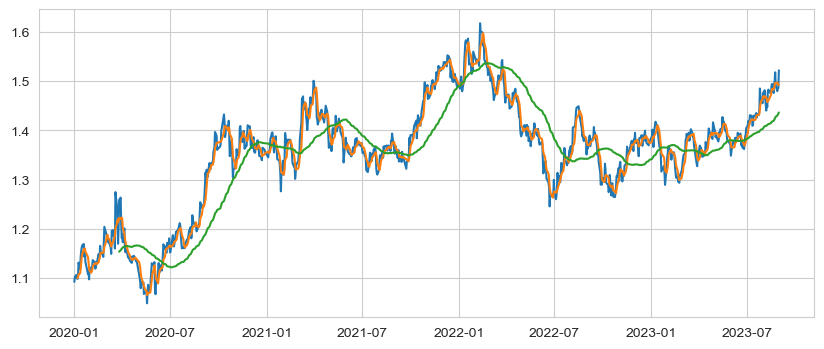

In [11]:
plt.figure(figsize = (10,4))
plt.plot(ratio)
plt.plot(ma5)
plt.plot(ma60)

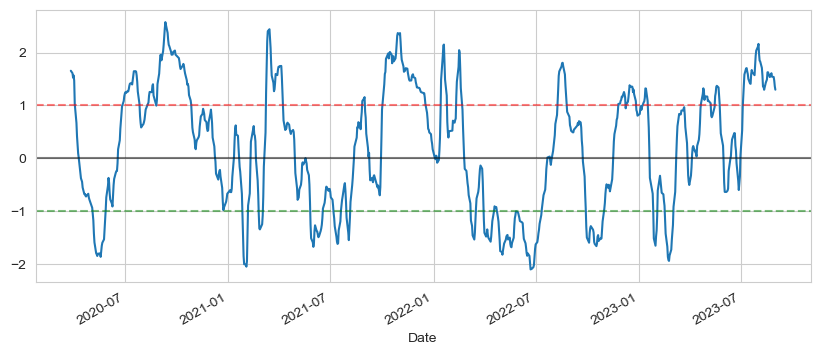

In [12]:
plt.figure(figsize = (10,4))
spread.plot(label = 'Spread')
plt.axhline(0, color = 'black', alpha = 0.5)
plt.axhline(1.0, color = 'red', linestyle = '--', alpha = 0.5)
plt.axhline(-1.0, color = 'green', linestyle = '--', alpha = 0.5)

#### 6. Trading Strategy

$\mathrm{Asset~ratio} = \frac{P_a}{P_b}$일 때, Spread가 -1 이하로 떨어지면 a자산을 매수 & b자산을 매도하는 매수전략을, 1 이상으로 상승하면 a자산 매도 & b 자산을 매수하는 매도전략을 취한다

pandas dataframe을 이용해 신한지주와 KB금융지주의 수익률과 spread, betting side으로 이뤄진 matrix를 생성하라

(hint : betting side는 전략의 방향을 결정하는 것으로, 1이면 매수, 0이면 유보, -1이면 매도로 표현한다)

In [13]:
bet = pd.concat([kb_ret, shinhan_ret, spread], axis = 1).dropna()
bet.columns = ['KB','Shinhan','spread']
bet['betting side'] = 0
bet.loc[bet['spread'] >= 1, 'betting side'] = -1
bet.loc[bet['spread'] <= -1, 'betting side'] = 1
bet

,KB,Shinhan,spread,betting side
Date,,,,
2020-03-27,0.083078,0.037673,1.655239,-1
2020-03-30,-0.028371,-0.032203,1.607559,-1
2020-03-31,-0.005772,0.039221,1.523859,-1
2020-04-01,-0.089250,-0.066872,1.566943,-1
2020-04-02,0.003160,0.000000,1.466970,-1
...,...,...,...,...
2023-08-25,-0.013245,0.004270,1.543281,-1
2023-08-28,0.001903,0.009894,1.537037,-1
2023-08-29,0.005687,0.001405,1.468357,-1


<Axes: xlabel='Date'>

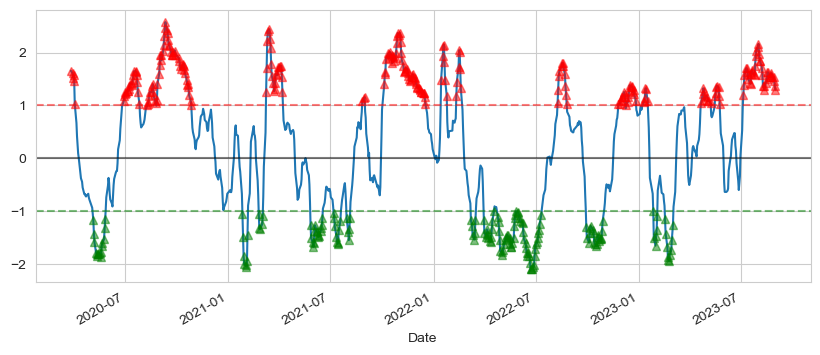

In [14]:
plt.figure(figsize = (10,4))
bet['spread'].plot(label = 'Spread')
plt.axhline(0, color = 'black', alpha = 0.5)
plt.axhline(1.0, color = 'red', linestyle = '--', alpha = 0.5)
plt.axhline(-1.0, color = 'green', linestyle = '--', alpha = 0.5)
bet['spread'][bet['betting side'] == 1].plot(color = 'g', linestyle = 'None', marker = '^', alpha = 0.5)
bet['spread'][bet['betting side'] == -1].plot(color = 'r', linestyle = 'None', marker = '^', alpha = 0.5)

#### 7. Backtesting

행렬에 backtest column을 추가하고 적절한 방법을 사용하여 성과를 Backtesting하라

In [15]:
bet['backtest'] = (-bet.KB + bet.Shinhan) * bet['betting side']
bet

,KB,Shinhan,spread,betting side,backtest
Date,,,,,
2020-03-27,0.083078,0.037673,1.655239,-1,0.045405
2020-03-30,-0.028371,-0.032203,1.607559,-1,0.003832
2020-03-31,-0.005772,0.039221,1.523859,-1,-0.044993
2020-04-01,-0.089250,-0.066872,1.566943,-1,-0.022378
2020-04-02,0.003160,0.000000,1.466970,-1,0.003160
...,...,...,...,...,...
2023-08-25,-0.013245,0.004270,1.543281,-1,-0.017516
2023-08-28,0.001903,0.009894,1.537037,-1,-0.007991
2023-08-29,0.005687,0.001405,1.468357,-1,0.004282


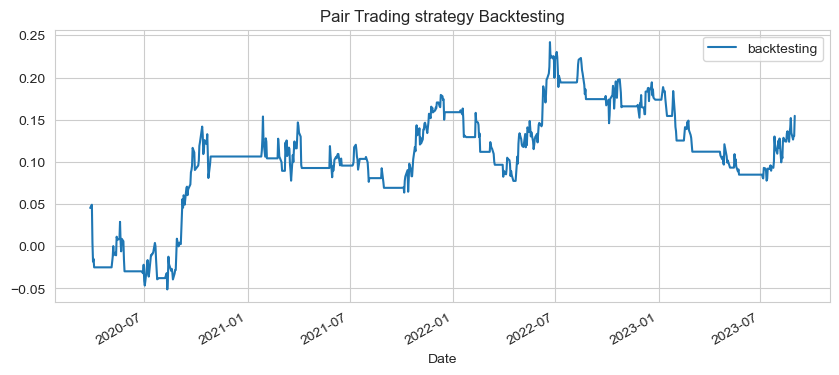

In [16]:
bet['backtest'].cumsum().plot(figsize = (10,4), label = 'backtesting')
plt.legend()
plt.title('Pair Trading strategy Backtesting')
plt.show()